# GANs - Generative Adverserial Networks (mnist Dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

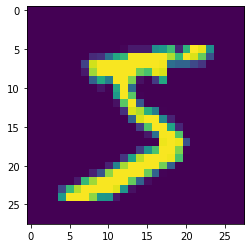

In [4]:
plt.imshow(X_train[0])

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Reshape and Rescale Images for DCGAN

Generator will use tanh activation function for the last layer, so we want to reshape X_train to be within -1 to 1 limits.

In [6]:
X_train = X_train/255

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [8]:
X_train.min()

-1.0

In [9]:
X_train.max()

1.0

## Filtering out the Data containing 8 

In [58]:
only_eight = X_train[y_train==8]

In [59]:
only_eight.shape

(5851, 28, 28, 1)

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [62]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))


In [63]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [64]:
GAN = Sequential([generator, discriminator])

In [65]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [66]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [67]:
GAN.layers

In [68]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [69]:
GAN.layers[0].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
______________________________________________

In [70]:
GAN.layers[1].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6273      
Total params: 425,730
Trainable params: 212,865
Non-trainable params: 212,865
__________________________________________

### Setting up Training Batches

In [71]:
import tensorflow as tf

In [72]:
batch_size = 32

In [73]:
# my_data = X_train
my_data = only_eight

In [74]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [76]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [77]:
epochs = 15

In [78]:
generator, discriminator = GAN.layers

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")

        #TRAINING THE DISCRIMINATOR
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        # TRAINING THE GENERATOR
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 20 of 182
	Currently on batch number 40 of 182
	Currently on batch number 60 of 182
	Currently on batch number 80 of 182
	Currently on batch number 100 of 182
	Currently on batch number 120 of 182
	Currently on batch number 140 of 182
	Currently on batch number 160 of 182
	Currently on batch number 180 of 182
Currently on Epoch 2
	Currently on batch number 20 of 182
	Currently on batch number 40 of 182
	Currently on batch number 60 of 182
	Currently on batch number 80 of 182
	Currently on batch number 100 of 182
	Currently on batch number 120 of 182
	Currently on batch number 140 of 182
	Currently on batch number 160 of 182
	Currently on batch number 180 of 182
Currently on Epoch 3
	Currently on batch number 20 of 182
	Currently on batch number 40 of 182
	Currently on batch number 60 of 182
	Currently on batch number 80 of 182
	Currently on batch number 100 of 182
	Currently on batch number 120 of 182
	Currently on batch number 140 of 182

# Most likely your generator will only learn to create one type of noisey eight

In [81]:
noise = tf.random.normal(shape=[30, codings_size])

In [82]:
noise.shape

TensorShape([30, 100])

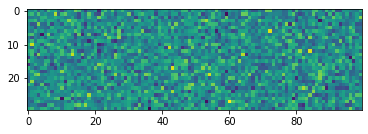

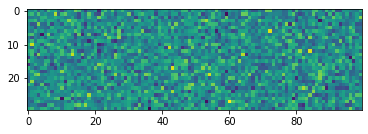

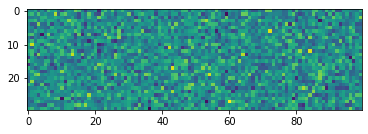

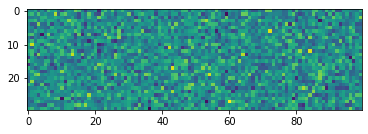

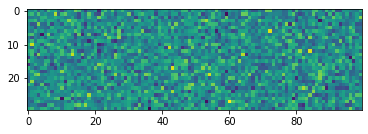

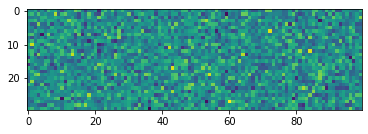

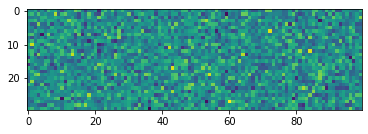

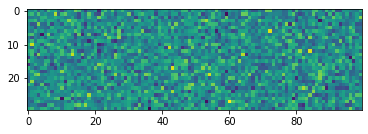

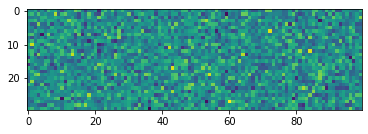

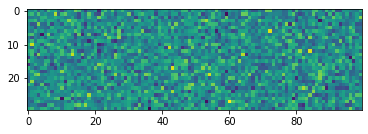

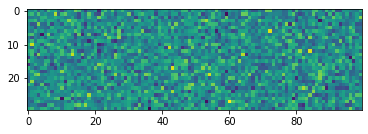

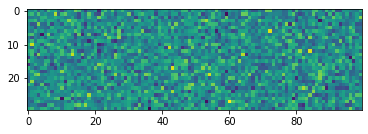

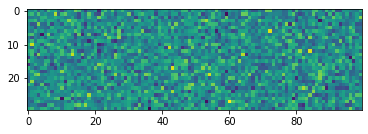

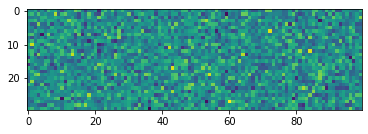

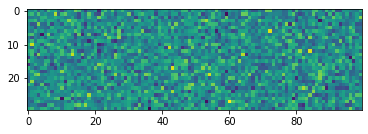

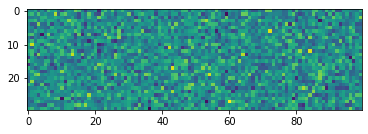

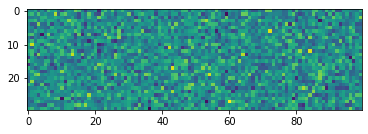

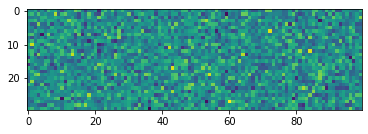

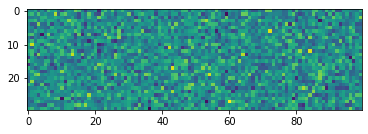

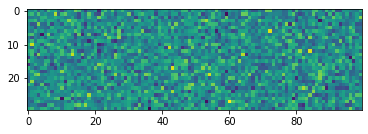

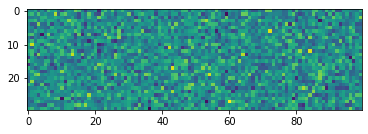

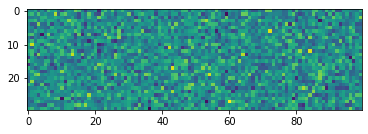

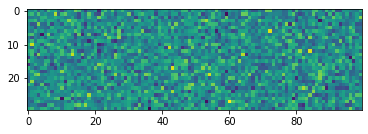

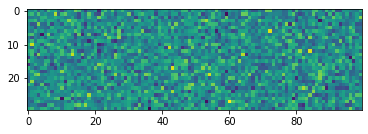

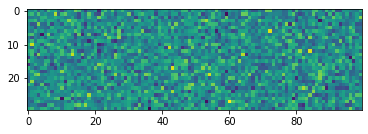

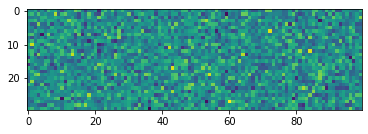

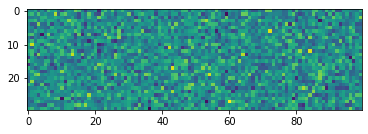

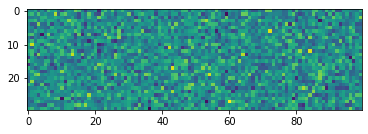

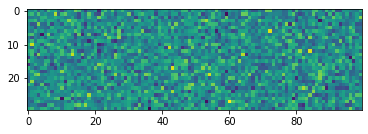

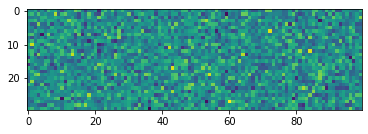

In [83]:
for image in noise:
    plt.imshow(noise)
    plt.show()

In [88]:
images = generator(noise)#noise previous

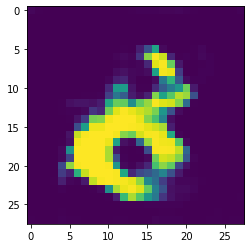

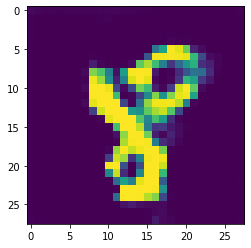

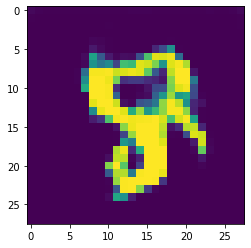

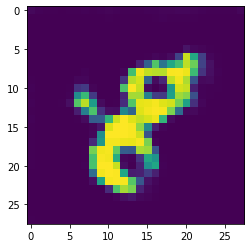

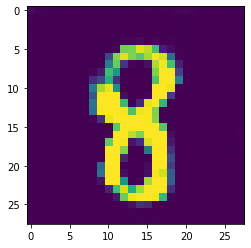

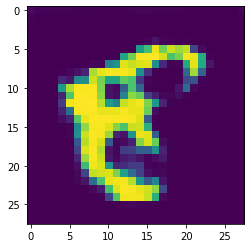

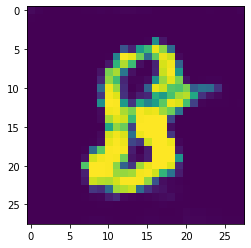

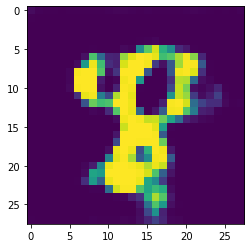

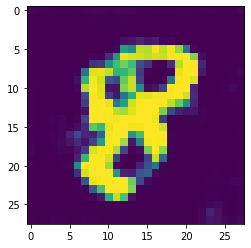

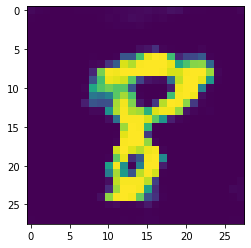

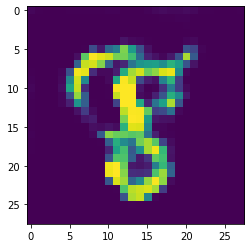

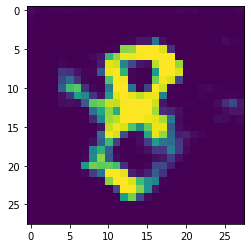

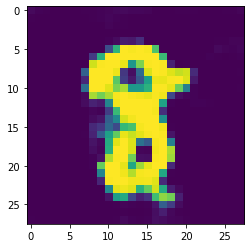

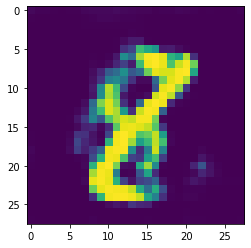

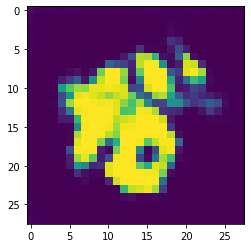

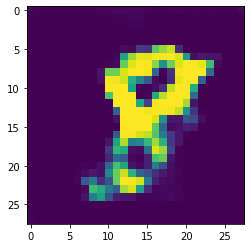

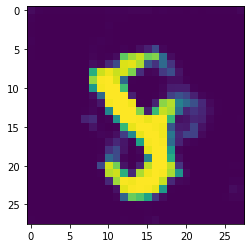

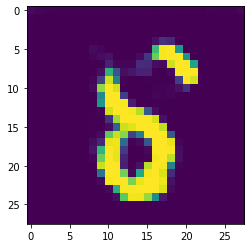

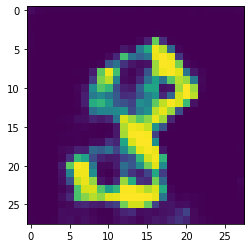

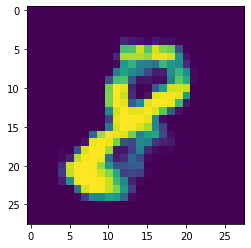

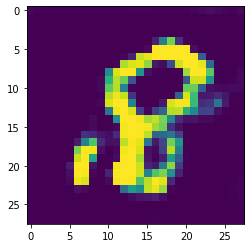

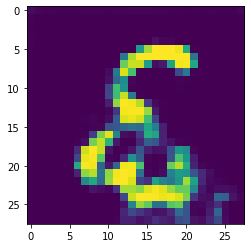

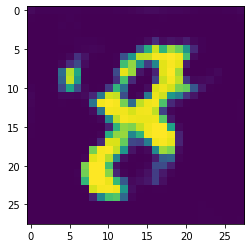

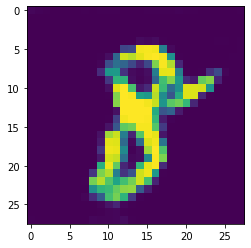

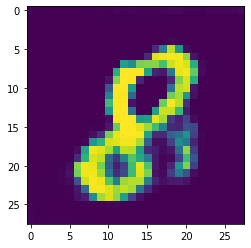

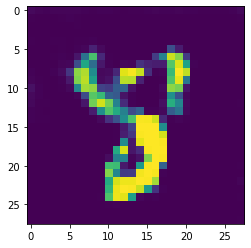

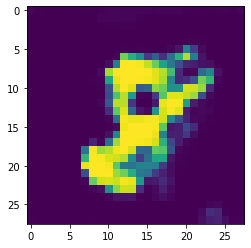

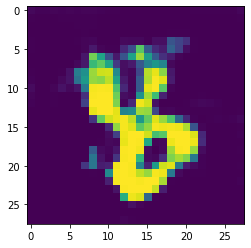

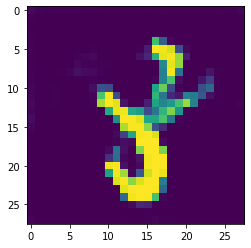

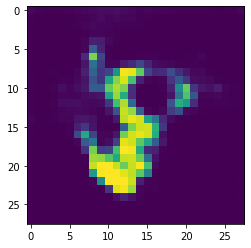

In [90]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()